In [1]:
import pandas as pd   
import numpy as np   
import pandas.io.data as web   
from datetime import datetime   
import scipy as sp   
import scipy.optimize as scopt   
import scipy.stats as spstats   
import matplotlib.pyplot as plt   
import matplotlib.mlab as mlab   
import math

%matplotlib inline   
pd.set_option('display.notebook_repr_html', False)   
pd.set_option('display.max_columns', 7)   
pd.set_option('display.max_rows', 10)    
pd.set_option('display.width', 82)    
pd.set_option('precision', 3)

/home/tom/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
def get_historical_closes(ticker, start_date, end_date):       
    p = web.DataReader(ticker, "yahoo", start_date, end_date)           
    d = p.to_frame()['Adj Close'].reset_index()       
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)       
    pivoted = d.pivot(index='Date', columns='Ticker')       
    pivoted.columns = pivoted.columns.droplevel(0)       
    return pivoted

In [3]:
closes = get_historical_closes(['VTI','VGK','EWJ','EEM','IEF','TLT','ICF','RWX','DBC','GLD'], '2013-01-01', '2014-12-31')

In [4]:
closes[:5]

Ticker        DBC     EEM    EWJ   ...        TLT     VGK     VTI
Date                               ...                           
2013-01-02  27.88  41.956  9.552   ...    107.983  43.211  69.971
2013-01-03  27.65  41.659  9.466   ...    106.520  42.704  69.868
2013-01-04  27.53  41.743  9.428   ...    106.935  43.063  70.222
2013-01-07  27.58  41.427  9.342   ...    106.981  42.888  70.036
2013-01-08  27.65  41.056  9.218   ...    107.685  42.748  69.850

[5 rows x 10 columns]

In [5]:
def calc_daily_returns(closes):       
    return np.log(closes/closes.shift(1))

In [6]:
daily_returns = calc_daily_returns(closes)   
# daily_returns[:5]

In [7]:
def calc_yearly_returns(daily_returns):       
    ret = np.exp(daily_returns.sum())-1       
    return ret

In [8]:
yearly_returns = calc_yearly_returns(daily_returns)   
yearly_returns

Ticker
DBC   -0.338
EEM   -0.092
EWJ    0.153
GLD   -0.304
ICF    0.302
IEF    0.029
RWX    0.075
TLT    0.118
VGK    0.142
VTI    0.465
dtype: float64

In [10]:
def calc_portfolio_var(returns, weights=None):       
    if (weights is None):            
        weights = np.ones(returns.columns.size) / returns.columns.size       
    sigma = np.cov(returns.T,ddof=0)       
    var = (weights * sigma * weights.T).sum()     
    return var   

In [11]:
calc_portfolio_var(yearly_returns)

0.0016094776092896606

In [12]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):       
    n = returns.columns.size       
    if weights is None: 
        weights = np.ones(n)/n       
    var = calc_portfolio_var(returns, weights)       
    means = returns.mean()       
    return (means.dot(weights) - risk_free_rate) / np.sqrt(var)   

In [13]:
sharpe_ratio(yearly_returns)

1.1631636272459254

In [14]:
# Need to maximize Sharpe ratio.  To do this iwth a minimize algo, we need to create a func to return neg Sharpe
# Minimize functions will provide best values for function parameters
def negative_sharpe_ratio_n_minus_1_stock(weights, returns, risk_free_rate):       
    """       
    Given n-1 weights, return a negative sharpe ratio       
    """       
    weights2 = sp.append(weights, 1-np.sum(weights))       
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [15]:
def optimize_portfolio(returns, risk_free_rate):       
    w0 = np.ones(returns.columns.size-1, dtype=float) * 1.0 / returns.columns.size       
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, w0, args=(returns, risk_free_rate))       
    final_w = sp.append(w1, 1 - np.sum(w1))       
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)       
    return (final_w, final_sharpe)

In [33]:
weights, fsharpe = optimize_portfolio(yearly_returns, 0.0003)

In [34]:
fsharpe, weights

(inf, array([ 0.05101792,  0.07772539,  0.16023172, -0.02440116,  0.18373488,
         0.11866519,  0.03080787,  0.13350475,  0.10838952,  0.16032392]))

In [18]:
weights.sum()

1.0

In [19]:
def objfun(W, R, target_ret):       
    stock_mean = np.mean(R,axis=0)       
    port_mean = np.dot(W,stock_mean)        
    cov=np.cov(R.T)        
    port_var = np.dot(np.dot(W,cov),W.T)        
    penalty = 2000*abs(port_mean-target_ret)       
    return np.sqrt(port_var) + penalty 

In [20]:
def calc_efficient_frontier(returns):       
    result_means = []       
    result_stds = []       
    result_weights = []           
    means = returns.mean()       
    min_mean, max_mean = means.min(), means.max()           
    nstocks = returns.columns.size           
    for r in np.linspace(min_mean, max_mean, 20):           
        weights = np.ones(nstocks)/nstocks           
        bounds = [(0,1) for i in np.arange(nstocks)]           
        constraints = ({'type': 'eq',  'fun': lambda W: np.sum(W) - 1})           
        results = scopt.minimize(objfun, weights, (returns, r), method='SLSQP', constraints = constraints, bounds = bounds)           
        if not results.success: 
            # handle error 
            raise Exception(result.message)           
        result_means.append(np.round(r,4)) # 4 decimal places           
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)           
        result_stds.append(std_)                   
        result_weights.append(np.round(results.x, 5))   
    return {'Means': result_means, 'Stds': result_stds, 'Weights': result_weights}

In [21]:
frontier_data = calc_efficient_frontier(yearly_returns)

In [22]:
frontier_data

{'Means': [-0.1174,
  -0.10059999999999999,
  -0.083699999999999997,
  -0.066900000000000001,
  -0.050000000000000003,
  -0.0332,
  -0.016299999999999999,
  0.00050000000000000001,
  0.017399999999999999,
  0.034200000000000001,
  0.0511,
  0.067900000000000002,
  0.0848,
  0.1016,
  0.11849999999999999,
  0.1353,
  0.1522,
  0.1691,
  0.18590000000000001,
  0.20280000000000001],
 'Stds': [0.12034,
  0.084291000000000005,
  0.071629999999999999,
  0.058969000000000001,
  0.049361000000000002,
  0.041133000000000003,
  0.032183000000000003,
  0.023869999999999999,
  0.015566,
  0.0076099999999999996,
  1.7e-05,
  2.1999999999999999e-05,
  3.0000000000000001e-06,
  9.0000000000000002e-06,
  9.6000000000000002e-05,
  9.3999999999999994e-05,
  1.7e-05,
  0.000105,
  0.023296999999999998,
  0.093620999999999996],
 'Weights': [array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.6329 ,  0.     ,  0.     ,  0.32459,  0.     ,  0.     ,
          0.     ,  0.04251,  0.     , 

In [23]:
frontier_data['Means'][:5]

[-0.1174,
 -0.10059999999999999,
 -0.083699999999999997,
 -0.066900000000000001,
 -0.050000000000000003]

In [24]:
frontier_data['Stds'][:5]

[0.12034,
 0.084291000000000005,
 0.071629999999999999,
 0.058969000000000001,
 0.049361000000000002]

In [25]:
# Minimum Variance Portfolio is found by identifying the index of the lowest variance datapoint
# Use that index to find the associated weights
x=frontier_data['Stds'].index(min(frontier_data['Stds']))
frontier_data['Weights'][x]

array([  1.03560000e-01,   7.00000000e-05,   1.23330000e-01,
         7.29400000e-02,   7.76600000e-02,   1.30600000e-01,
         6.00000000e-05,   1.57790000e-01,   8.00000000e-05,
         3.33920000e-01])

In [26]:
frontier_data['Weights'][:5]

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.6329 ,  0.     ,  0.     ,  0.32459,  0.     ,  0.     ,
         0.     ,  0.04251,  0.     ,  0.     ]),
 array([ 0.6617,  0.    ,  0.    ,  0.1766,  0.    ,  0.    ,  0.    ,
         0.1617,  0.    ,  0.    ]),
 array([ 0.68963,  0.     ,  0.     ,  0.02965,  0.     ,  0.     ,
         0.     ,  0.28072,  0.     ,  0.     ]),
 array([ 0.59667,  0.     ,  0.00921,  0.     ,  0.     ,  0.12132,
         0.     ,  0.2728 ,  0.     ,  0.     ])]

In [27]:
def plot_efficient_frontier(ef_data):       
    plt.figure(figsize=(12,8))       
    plt.title('Efficient Frontier')       
    plt.xlabel('Standard Deviation of the porfolio (Risk))')       
    plt.ylabel('Return of the portfolio')       
    plt.plot(ef_data['Stds'], ef_data['Means'], '--');  

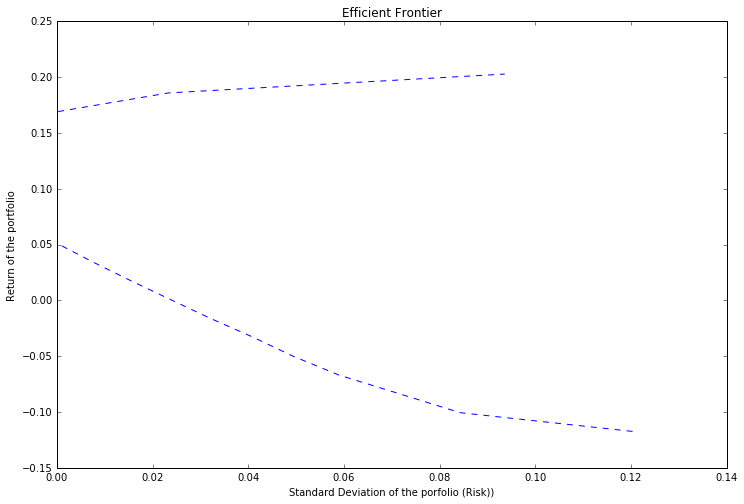

In [28]:
plot_efficient_frontier(frontier_data)

14.400000000000002